In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, learning_curve,LearningCurveDisplay, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import *
from sklearn.pipeline import make_pipeline, Pipeline
import seaborn as sns
import random

In [2]:
import pickle

# Save model
def save_model(file_name, model):
    with open('model/'+file_name,'wb') as f:
        pickle.dump(model,f)
    f.close()

# Load model
def load_model(file_name):
    with open('model/'+file_name,'rb') as f:
        model = pickle.load(f)
    f.close()
    return model

### READ DATASET

In [3]:
data = pd.read_csv("weather_data.csv", sep = ";")
data["target"] = data.shift(-1)["weather"]                      # We need to predict the weather in next 3 hours (the label of next row)

data.drop('weather', axis=1, inplace=True)
data.drop(data.tail(1).index, inplace=True)                     # Drop last row since its label is incorrect

print(data.shape)

(8511, 12)


# DATA PREPROCESSING

### 1. DATA PROFILING

time              object
month              int64
temperature      float64
feelslike        float64
wind             float64
direction         object
gust             float64
cloud            float64
humidity         float64
precipitation    float64
pressure         float64
target            object
dtype: object


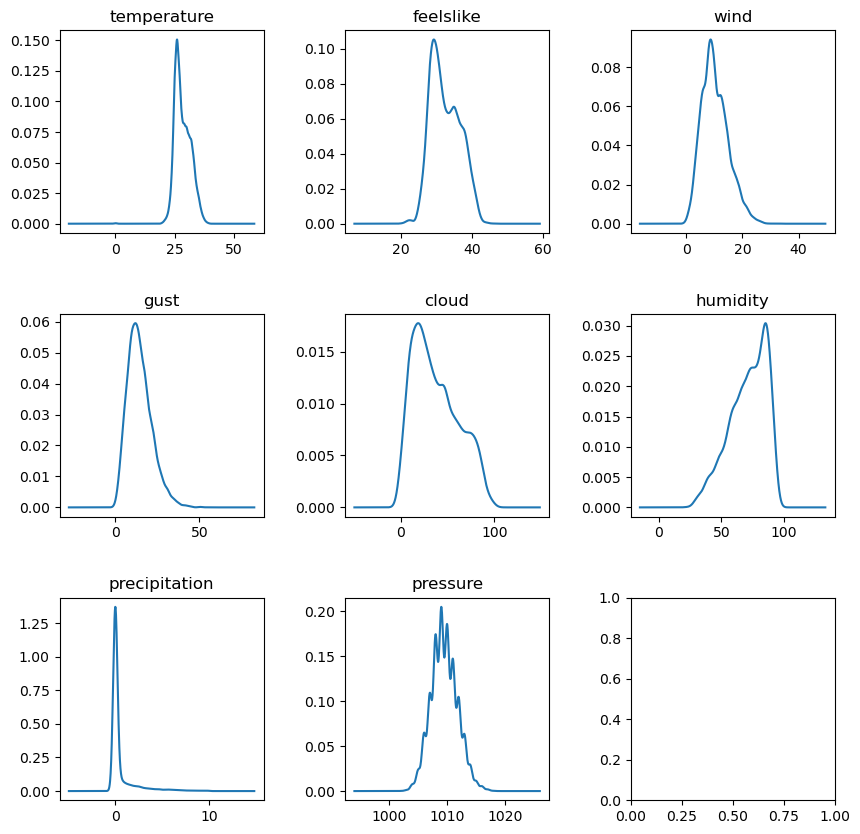

In [4]:

print(data.dtypes)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

num_attr = ['temperature', 'feelslike', 'wind', 'gust', 'cloud', 'humidity', 'precipitation', 'pressure']
for i in  range(len(num_attr)):
    a = num_attr[i]
    data[a].plot(ax=axs[i//3,i%3],kind='kde', xlabel=a)
    axs[i//3,i%3].set_title(a)
    axs[i//3,i%3].set_ylabel("")
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

### 2.DATA CLEANSING

In [5]:
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(axis=1)]
print(data.shape)

(8511, 12)


### DATA TRANSFORMATION

In [6]:
# Transform the label to rain possiblity label
label_map = {
    'Heavy rain at times': 'Heavy/moderate rain',
    'Heavy rain': 'Heavy/moderate rain',
    'Moderate rain at times':'Heavy/moderate rain',
    'Moderate rain':'Heavy/moderate rain',
    'Mist': 'Mist/drizzle',
    'Light drizzle': 'Mist/drizzle',
    'Light rain': 'Light rain',
    'Patchy light drizzle': 'Mist/drizzle',
    'Patchy light rain with thunder': 'Light rain',
    'Patchy light rain': 'Light rain',
    'Torrential rain shower': 'Heavy/moderate rain',
    'Thundery outbreaks possible': 'Cloudy',
    'Overcast': 'Heavy/moderate rain',
    'Light rain shower': 'Light rain',
    'Cloudy': 'Cloudy',
    'Moderate or heavy rain shower': 'Heavy/moderate rain',
    'Patchy rain possible': 'Light rain',
    'Sunny': 'Sunny',
    'Clear': 'Clear',
    'Partly cloudy': 'Cloudy',
}

data['target'] = data['target'].map(label_map)
print(data['target'].value_counts())

Cloudy                 4294
Light rain             1179
Clear                  1102
Sunny                  1003
Heavy/moderate rain     864
Mist/drizzle             69
Name: target, dtype: int64


In [7]:
time_le = LabelEncoder()
data['time'] = pd.DataFrame(data['time'].to_numpy()).apply(time_le.fit_transform)
direction_le = LabelEncoder()
data['direction'] = pd.DataFrame(data['direction'].to_numpy()).apply(direction_le.fit_transform)

0.9165691923669825


0.9291408046353925


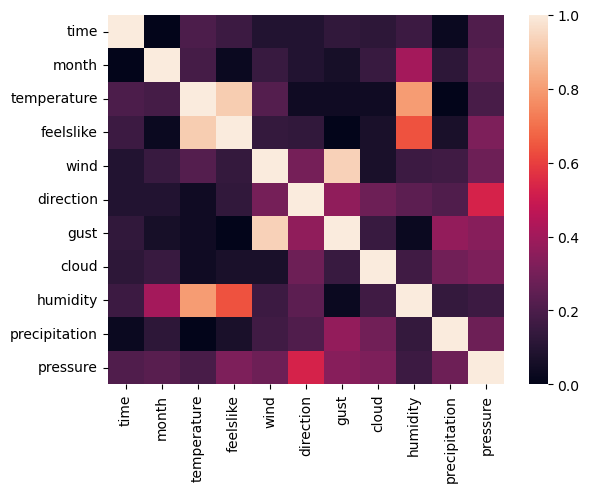

In [8]:
matrix = data.corr(numeric_only=True).abs().round(2)
sns.heatmap(matrix)
print(data['temperature'].corr(data['feelslike']))
print(data['wind'].corr(data['gust']))
plt.show()

### DATA BALANCING

In [9]:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
o_spl = SMOTE()
x = data.drop('target', axis=1)
y = data['target']

x_balanced, y_balanced = o_spl.fit_resample(x, y)
print(y_balanced.value_counts())

Clear                  4294
Sunny                  4294
Cloudy                 4294
Light rain             4294
Heavy/moderate rain    4294
Mist/drizzle           4294
Name: target, dtype: int64


In [10]:
clf = make_pipeline(StandardScaler(),SVC())
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size = 0.2, random_state = random.randint(1,999))


In [11]:
# def display_learning_curve(model, x, y):
#     train_sizes, train_scores, test_scores = learning_curve(model,x,y)
#     train_mean = np.mean(train_scores, axis=1)
#     train_std = np.std(train_scores, axis=1)
#     test_mean = np.mean(test_scores, axis=1)
#     test_std = np.std(test_scores, axis=1)

#     plt.plot(train_sizes, train_mean, label='Train accuracy')
#     plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.2)
#     plt.plot(train_sizes, test_mean, label='Train accuracy')
#     plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.2)

#     plt.title('Learning curve')
#     plt.ylabel('Score')
#     plt.xlabel('Number of samples')
#     plt.legend()
#     plt.show()

# display_learning_curve(clf,x_balanced, y_balanced)

In [12]:
# def hyper_C_test(x,y, *c_list):
#     if(not c_list) :
#        c_list = [0.01, 0.1, 0.3, 0.9, 2, 6, 15, 100, 1000]
#     x_graph = np.log(c_list)
#     y_graph = []
#     for i in c_list:
#         clf = make_pipeline(StandardScaler(),SVC(C=i))
#         x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)
#         clf.fit(x_train, y_train)
#         y_pred = clf.predict(x_test)
#         y_graph.append(accuracy_score(y_test,y_pred))
#     plt.plot(x_graph, y_graph, label='Train accuracy')
#     plt.title('Model with different C')
#     plt.ylabel('Score')
#     plt.xlabel('Value of ln(C)')
#     plt.legend()
#     plt.show()
# hyper_C_test(x_balanced,y_balanced)


In [13]:
# def hyper_kernel_test(x,y, *c_list):
#     if(not c_list) :
#        c_list = ['linear', 'poly', 'rbf', 'sigmoid']
   
#     y_graph_mean = []
#     y_graph_std = []
#     for i in c_list:
#         y_data = []
#         for j in range(5):
#             clf = make_pipeline(StandardScaler(),SVC(kernel=i))
#             x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = random.randint(1,999))
#             clf.fit(x_train, y_train)
#             y_pred = clf.predict(x_test)
#             y_data.append(accuracy_score(y_test,y_pred))
#         y_graph_mean.append(np.mean(np.array(y_data)))
#         y_graph_std.append(np.std(np.array(y_data)))
#     y_graph_mean = np.array(y_graph_mean)
#     y_graph_std = np.array(y_graph_std)

#     plt.plot(c_list, y_graph_mean, label='Train accuracy')

#     plt.fill_between(c_list, y_graph_mean+y_graph_std, y_graph_mean- y_graph_std, alpha=0.2)
#     plt.title('Model with different kernel')
#     plt.ylabel('Score')
#     plt.xlabel('Kernel')
#     plt.legend()
#     plt.show()
# hyper_kernel_test(x_balanced,y_balanced)

In [ ]:
# def pca_test(x,y, *c_list):
    
#     if(not c_list) :
#        c_list = [i for i in range(3,11)]+['mle']
#     y_graph = []
#     clf = make_pipeline(StandardScaler(),SVC())
#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = random.randint(1,999))
#     clf.fit(x_train, y_train)
#     y_pred = clf.predict(x_test)
#     y_graph.append(accuracy_score(y_test,y_pred))
#     for i in c_list:
#         clf = make_pipeline(StandardScaler(),PCA(n_components=i),SVC())
#         x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = random.randint(1,999))
#         clf.fit(x_train, y_train)
#         y_pred = clf.predict(x_test)
#         y_graph.append(accuracy_score(y_test,y_pred))
#     plt.plot([11]+c_list, y_graph, label='Train accuracy')
#     plt.title('Model with different C')
#     plt.ylabel('Score')
#     plt.xlabel('Value of ln(C)')
#     plt.legend()
#     plt.show()
# pca_test(x_balanced,y_balanced)


In [15]:
clf.fit(x_train,y_train)
y_predict = clf.predict(x_test)


Accuracy score: 0.7735299825344459
Recall score: 0.7685113700015487
Precision score: 0.7654935758666458
F1 score: 0.7614094317953713


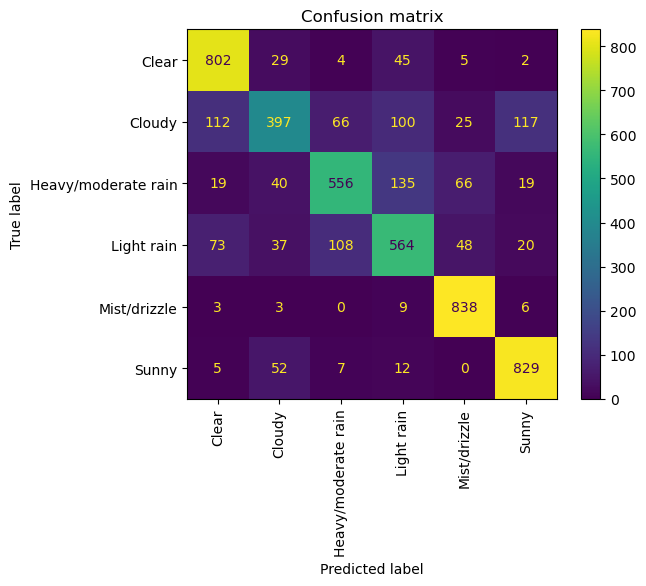

In [16]:
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(f'Recall score: {recall_score(y_test, y_predict, average="macro")}')
print(f'Precision score: {precision_score(y_test, y_predict, average="macro")}')
print(f'F1 score: {f1_score(y_test, y_predict, average="macro")}')
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_predict), display_labels=clf.classes_).plot()
plt.xticks(rotation = 90)
plt.title('Confusion matrix')
plt.show()